In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from mssa import MSSA

%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
gaussian = lambda x : np.exp(-0.5 * x**2)
rectangular = lambda x : 1 * (x < 1 + 1e-6)
epanechnikov = lambda x : np.maximum(1 - x**2, 0)
epanechnikov_like = lambda x : (1 - 0.5 * x**2) * (x <=1 )

# Expretiments on artificial datasets

### Gaussian mixture sampling

In [4]:
def generate_normal(mu, Sigma):
    
    d = mu.shape[0]
    Sigma12 = sqrtm(Sigma)
    
    sample = np.random.randn(d)
    sample = Sigma12.dot(sample) + mu
    
    return sample

In [5]:
def sample_gaussian(n_classes, sample_size, class_proba, mu, Sigma):
    X = []
    y = []
    
    s = np.tril(np.ones((n_classes,n_classes))).dot(class_proba)
    
    for i in range(sample_size):

        # define a class to generate
        random = np.random.rand()
        cl = np.min(np.argwhere(s + 1e-15 > random))

        # sample
        X += [generate_normal(mu[cl], Sigma[cl])]
        y += [cl]

    X = np.array(X)
    y = np.array(y)
    
    return(X, y)

## Experiment 1

In [6]:
# Training sample

n_classes = 3
sample_size = 500
class_proba = np.ones(n_classes) / n_classes

mu = np.array([[0, -1], [np.sqrt(3)/2, 0], [-np.sqrt(3)/2, 0]])
Sigma = np.array([0.5 * np.identity(2), 0.5 * np.identity(2), 0.5 * np.identity(2)])

X, y = sample_gaussian(n_classes, sample_size, class_proba, mu, Sigma)
print(X.shape, y.shape)

(500, 2) (500,)


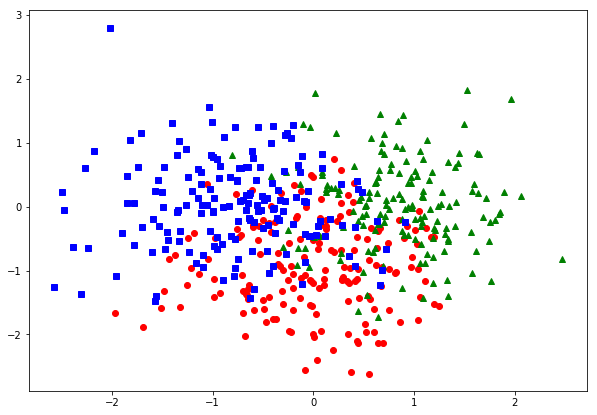

In [7]:
colors = ['ro', 'g^', 'bs', 'yv']

plt.figure(figsize=(10,7))
for i in range(n_classes):
    plt.plot(X[y==i, 0], X[y==i, 1], colors[i])
plt.show()
plt.close()

### Initialize estimator

In [8]:
n_neighbors = (3 * 1.25**(1 + np.arange(12))).astype(int)
print(n_neighbors)

[ 3  4  5  7  9 11 14 17 22 27 34 43]


In [9]:
mssa = MSSA(n_neighbors=n_neighbors, loc_kernel=rectangular)

#for delta in np.arange(0.7, 0.96, 0.05):
for delta in [0.75]:

    # tune critical values
    z = mssa.tune_critical_values(X[1:, :], X[0,:].reshape(-1), confidence=delta, n_classes=n_classes)
    #print(z)

    #for c in np.arange(0.5, 1.5, 0.1):
    #for c in np.arange(1.5, 2.5, 0.1):
    for c in [0.9]:
        mssa_err = 0
        knn_err = np.zeros(n_neighbors.shape)
        for i in range(sample_size):

            x_test = X[i, :].reshape(-1)
            y_test = y[i]
            X_train = np.delete(X, i, axis=0)
            y_train = np.delete(y, i)

            y_mssa, y_knn = mssa.predict(X_train, y_train, x_test, c * z)

            mssa_err += 1./sample_size * (y_test != y_mssa)
            knn_err += 1./sample_size * (y_test != y_knn)

        print('delta = ', delta, ', c = ', c, ', err = ', mssa_err)
print(np.min(knn_err))

delta =  0.75 , c =  0.9 , err =  0.244
0.254


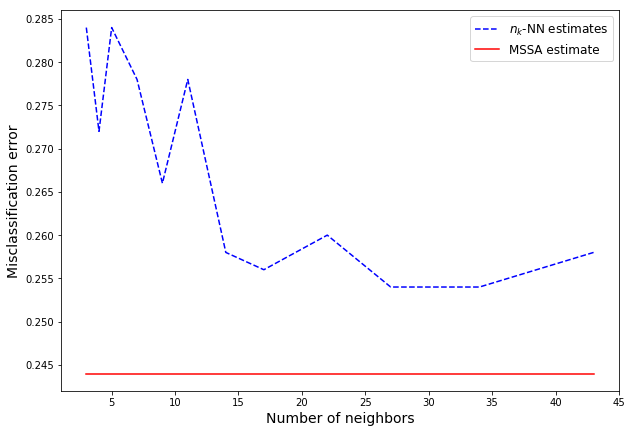

In [10]:
plt.figure(figsize=(10,7))
plt.plot(n_neighbors, knn_err, 'b--', label='$n_k$-NN estimates')
plt.plot(n_neighbors, mssa_err * np.ones(n_neighbors.shape[0]), 'r-', label='MSSA estimate')
#plt.plot(np.arange(n_neighbors.shape[0]), knn_err, 'b--', label='$n_k$-NN estimates')
#plt.plot(np.arange(n_neighbors.shape[0]), mssa_err * np.ones(n_neighbors.shape[0]), 'r-', label='MSSA estimate')
plt.ylabel('Misclassification error', fontsize=14)
plt.xlabel('Number of neighbors', fontsize=14)
#plt.xlabel('Index of the weighted nearest neighbor estimate', fontsize=14)
plt.legend(loc=0, fontsize=12)
plt.show()

## Experiment 2

In [11]:
# Training sample

n_classes = 4
sample_size = 500
class_proba = np.ones(n_classes) / n_classes

mu = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
Sigma = np.array([0.7 * np.identity(2), 0.7 * np.identity(2), 0.7 * np.identity(2), 0.7 * np.identity(2)])

X, y = sample_gaussian(n_classes, sample_size, class_proba, mu, Sigma)
print(X.shape, y.shape)

(500, 2) (500,)


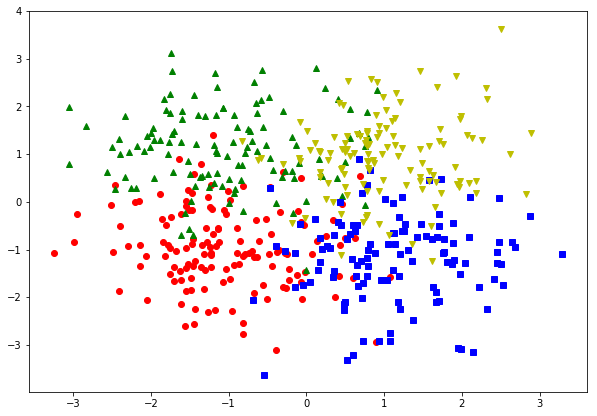

In [12]:
colors = ['ro', 'g^', 'bs', 'yv']

plt.figure(figsize=(10,7))
for i in range(n_classes):
    plt.plot(X[y==i, 0], X[y==i, 1], colors[i])
plt.show()
plt.close()

In [13]:
n_neighbors = (3 * 1.25**(1 + np.arange(16))).astype(int)
print(n_neighbors)

[  3   4   5   7   9  11  14  17  22  27  34  43  54  68  85 106]


### Initialize estimator

In [14]:
mssa = MSSA(n_neighbors=n_neighbors)

#for delta in np.arange(0.7, 0.96, 0.05):
for delta in [0.7]:

    # tune critical values
    z = mssa.tune_critical_values(X[1:, :], X[0,:].reshape(-1), confidence=delta, n_classes=n_classes)
    #print(z)

    #for c in np.arange(0.5, 1.5, 0.1):
    for c in [1.0]:
        mssa_err = 0
        knn_err = np.zeros(n_neighbors.shape)
        for i in range(sample_size):

            x_test = X[i, :].reshape(-1)
            y_test = y[i]
            X_train = np.delete(X, i, axis=0)
            y_train = np.delete(y, i)

            y_mssa, y_knn = mssa.predict(X_train, y_train, x_test, c * z)

            mssa_err += 1./sample_size * (y_test != y_mssa)
            knn_err += 1./sample_size * (y_test != y_knn)

        print('delta = ', delta, ', c = ', c, ', err = ', mssa_err)
print(np.min(knn_err))

delta =  0.7 , c =  1.0 , err =  0.192
0.194


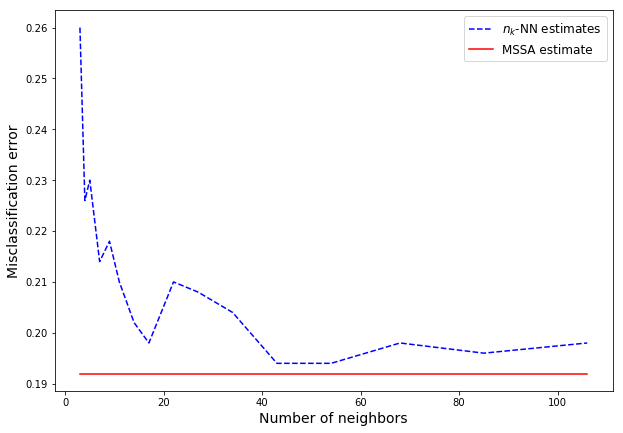

In [15]:
plt.figure(figsize=(10,7))
plt.plot(n_neighbors, knn_err, 'b--', label='$n_k$-NN estimates')
plt.plot(n_neighbors, mssa_err * np.ones(n_neighbors.shape[0]), 'r-', label='MSSA estimate')
#plt.plot(np.arange(n_neighbors.shape[0]), knn_err, 'b--', label='$n_k$-NN estimates')
#plt.plot(np.arange(n_neighbors.shape[0]), mssa_err * np.ones(n_neighbors.shape[0]), 'r-', label='MSSA estimate')
plt.ylabel('Misclassification error', fontsize=14)
plt.xlabel('Number of neighbors', fontsize=14)
#plt.xlabel('Index of the weighted nearest neighbor estimate', fontsize=14)
plt.legend(loc=0, fontsize=12)
plt.show()

## Experiment 3

In [16]:
# Training sample

n_classes = 6
sample_size = 500
class_proba = np.ones(n_classes) / n_classes

mu = 1.5 * np.array([[1, 0], [0.5, np.sqrt(3)/2], [-0.5, np.sqrt(3)/2], [-1, 0], [-0.5, -np.sqrt(3)/2], [0.5, -np.sqrt(3)/2]])
Sigma = np.array([0.5 * np.identity(2), 0.5 * np.identity(2), 0.5 * np.identity(2), 0.5 * np.identity(2), 0.5 * np.identity(2), 0.5 * np.identity(2)])

X, y = sample_gaussian(n_classes, sample_size, class_proba, mu, Sigma)

y = y % 3
n_classes = 3

print(X.shape, y.shape)

(500, 2) (500,)


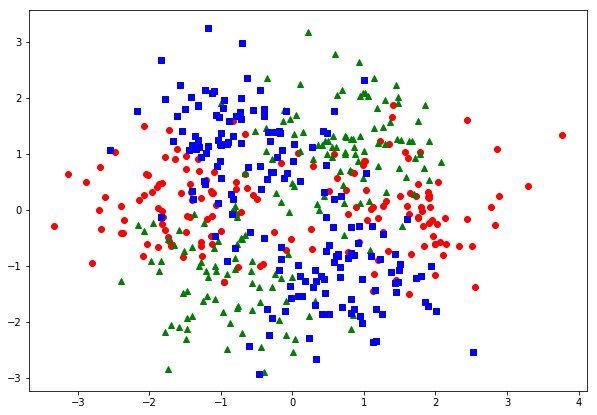

In [17]:
colors = ['ro', 'g^', 'bs', 'yv']

plt.figure(figsize=(10,7))
for i in range(n_classes):
    plt.plot(X[y==i, 0], X[y==i, 1], colors[i])
plt.show()
plt.close()

In [18]:
n_neighbors = (3 * 1.25**(1 + np.arange(15))).astype(int)
print(n_neighbors)

[ 3  4  5  7  9 11 14 17 22 27 34 43 54 68 85]


### Initialize estimator

In [19]:
mssa = MSSA(n_neighbors=n_neighbors, loc_kernel=rectangular)

#for delta in np.arange(0.7, 0.96, 0.05):
for delta in [0.8]:

    # tune critical values
    z = mssa.tune_critical_values(X[1:, :], X[0,:].reshape(-1), confidence=delta, n_classes=n_classes)
    #print(z)

    #for c in np.arange(0.5, 1.5, 0.1):
    #for c in np.arange(0.1, 0.5, 0.1):
    for c in [1.2]:
        mssa_err = 0
        knn_err = np.zeros(n_neighbors.shape)
        for i in range(sample_size):

            x_test = X[i, :].reshape(-1)
            y_test = y[i]
            X_train = np.delete(X, i, axis=0)
            y_train = np.delete(y, i)

            y_mssa, y_knn = mssa.predict(X_train, y_train, x_test, c * z)

            mssa_err += 1./sample_size * (y_test != y_mssa)
            knn_err += 1./sample_size * (y_test != y_knn)

        print('delta = ', delta, ', c = ', c, ', err = ', mssa_err)
print(np.min(knn_err))

delta =  0.8 , c =  1.2 , err =  0.302
0.306


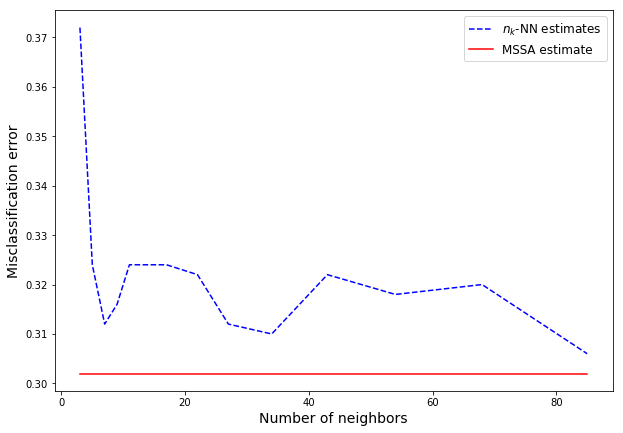

In [20]:
plt.figure(figsize=(10,7))
plt.plot(n_neighbors, knn_err, 'b--', label='$n_k$-NN estimates')
plt.plot(n_neighbors, mssa_err * np.ones(n_neighbors.shape[0]), 'r-', label='MSSA estimate')
#plt.plot(np.arange(n_neighbors.shape[0]), knn_err, 'b--', label='$n_k$-NN estimates')
#plt.plot(np.arange(n_neighbors.shape[0]), mssa_err * np.ones(n_neighbors.shape[0]), 'r-', label='MSSA estimate')
plt.ylabel('Misclassification error', fontsize=14)
plt.xlabel('Number of neighbors', fontsize=14)
#plt.xlabel('Index of the weighted nearest neighbor estimate', fontsize=14)
plt.legend(loc=0, fontsize=12)
plt.show()